In [1]:
import os
from utils.configuration import *

In [2]:
experiment_name = "ordinal_vars_test"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists/home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/configuration.json


In [4]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'x2':'continous',
            'x3':'continous',
            't1':'ordinal_Xn_Yo',
            't2':'ordinal_Xn_Yo',
            'x5':'continous',
            'x6':'continous',
            'y':'continous'} 

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
x3                   | continous       | continuous [c]                 | continuous [c]                
t1                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
t2                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
x5                   | continous       | continuous [c]  

/home/bule/TramDag/utils/configuration.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


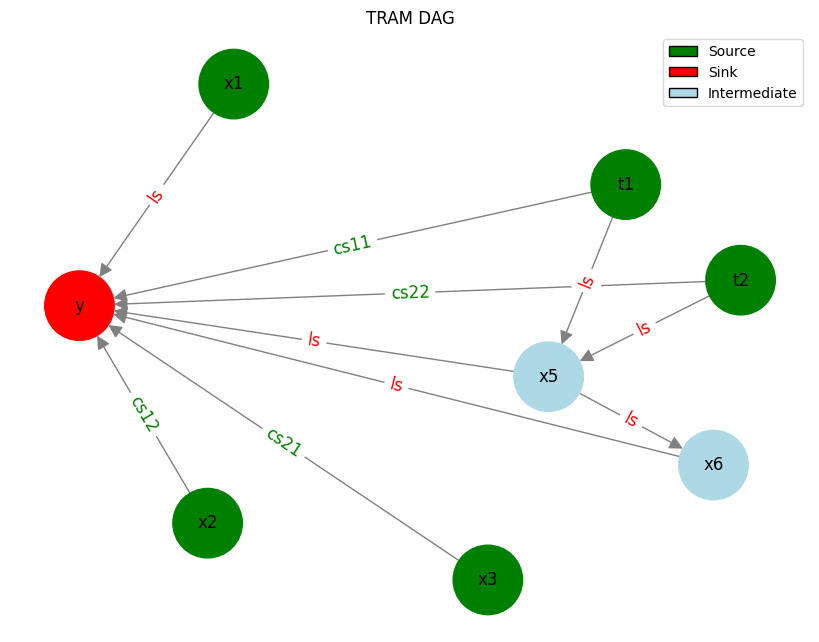

In [5]:
interactive_adj_matrix(CONF_DICT_PATH,seed=19)

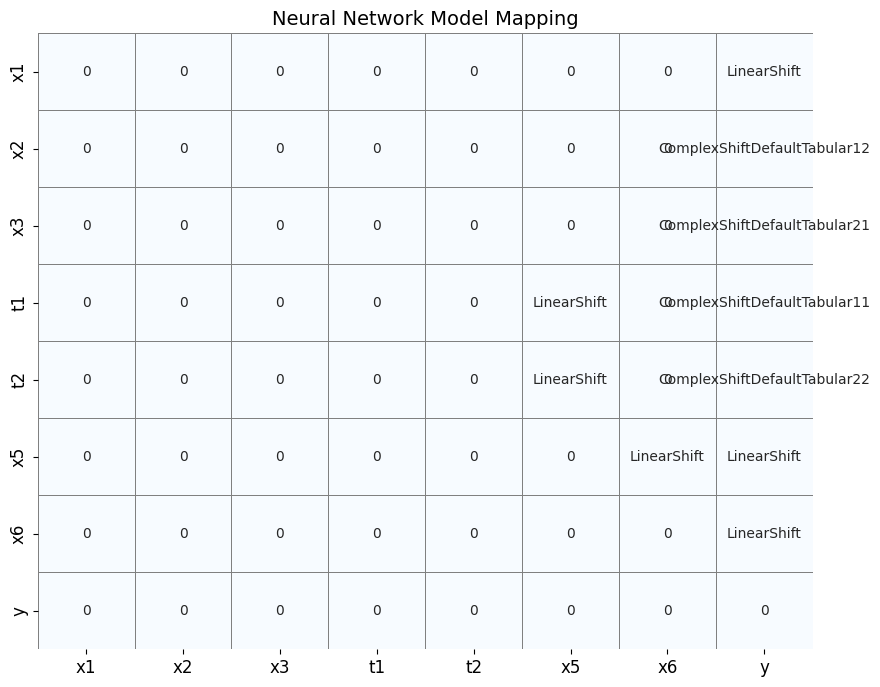

In [6]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
from scipy.special import logit

df = pd.DataFrame(
    make_blobs(n_samples=10_000, centers=8, n_features=8, random_state=13)[0],
    columns=['x1','x2','x3','x5','t1','t2','x6','y']
)


df['t1'] = (df['t1'] > df['t1'].median()).astype(int)
df['t2']=df['t1'].copy()
print(df.head())
df.info()


         x1         x2        x3        x5  t1  t2        x6         y
0  3.758992  -1.131220 -0.095220  9.899652   0   0  3.906152 -3.767058
1 -8.768500 -10.650421  2.893708  9.475817   0   0  7.026890 -8.332300
2  9.450577   5.692370 -3.912306  0.038899   1   1  5.710581 -2.963938
3  3.996866   4.773048 -9.309254 -4.166017   0   0 -2.438505  2.368463
4  2.789833   4.072897 -8.760611 -2.006136   0   0 -2.966617  2.577728
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  float64
 2   x3      10000 non-null  float64
 3   x5      10000 non-null  float64
 4   t1      10000 non-null  int64  
 5   t2      10000 non-null  int64  
 6   x6      10000 non-null  float64
 7   y       10000 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 625.1 KB


In [8]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [9]:
from utils.tramdag import TramDagConfig , TramDagModel

cfg = TramDagConfig.load("/home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/configuration.json")
cfg.compute_levels(train_df)
device='cpu'

In [10]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=True,device=device,initial_data = train_df) 
# 1m52s

[DEBUG] TramDagModel using device: cpu

[INFO] Building model for node 'x1' with settings: {'set_initial_weights': False, 'debug': True, 'verbose': True, 'device': 'cpu', 'initial_data':              x1        x2         x3        x5  t1  t2        x6         y
9254   5.790936 -7.249819   6.229806  6.689151   1   1  1.649284  6.730776
1561   2.400405  4.557155  -9.872843 -6.638451   0   0 -1.641476  2.115917
1670  -9.930820 -9.865590   1.492166  6.758005   0   0  5.124343 -7.871000
6087   4.827056 -5.193179   5.285507  9.157148   1   1  1.794985  7.551717
6669   6.572506 -4.023019   5.458759  9.673777   1   1  0.357335  5.307645
...         ...       ...        ...       ...  ..  ..       ...       ...
5734  10.089638  3.268733  -6.138526  1.147616   1   1  4.632081 -1.416370
5191   8.794295  3.537923  -5.136052  1.756384   1   1  7.567315 -1.000883
5390  -4.647563  2.710111  10.264334 -6.417286   1   1 -2.431899  3.603696
860   -8.692852 -8.695716   1.769343  5.199065   0   0  6.42181

In [ ]:
td_model.fit(train_df, val_df,
             epochs=1000,batch_size=1_000,
             verbose=True,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

#30 eps 1m 49s seq mode from start 1000 bs
#30 eps 2m 27s parllel multiprocessing mode from start 1000 bs
# 200 eps 9m 30s seq mode from start 1000 bs

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/min_max_scaling.json
[INFO] Training 8 nodes (sequential) on cpu

[INFO] Training node 'x1' for 1000 epochs on cpu (pid=120454)
[INFO] Existing model found. Loading weights and history...

===== Epoch 101/1000 =====


[INFO] Saved new best model.
[INFO] Epoch 101: Train NLL=3.2512 | Val NLL=3.2538 | Time=0.50s

===== Epoch 102/1000 =====
[INFO] Saved new best model.
[INFO] Epoch 102: Train NLL=3.2448 | Val NLL=3.2476 | Time=0.15s

===== Epoch 103/1000 =====
[INFO] Saved new best model.
[INFO] Epoch 103: Train NLL=3.2385 | Val NLL=3.2415 | Time=0.17s

===== Epoch 104/1000 =====
[INFO] Saved new best model.
[INFO] Epoch 104: Train NLL=3.2325 | Val NLL=3.2357 | Time=0.14s

===== Epoch 105/1000 =====
[INFO] Saved new best model.
[INFO] Epoch 105: Train NLL=3.2266 | Val NLL=3.2300 | Time=0.13s

===== Epoch 106/1000 =====
[INFO] Saved new best model.
[INFO] Epoch 106: Train NLL=3.2210 | Val NLL=3.2246 | Time=0.16s

===== Epoch 107/1000 =====
[INFO] Saved new best model.
[INFO] Epoch 107: Train NLL=3.2156 | Val NLL=3.2194 | Time=0.12s

===== Epoch 108/1000 =====
[INFO] Saved new best model.
[INFO] Epoch 108: Train NLL=3.2104 | Val NLL=3.2143 | Time=0.12s

===== Epoch 109/1000 =====
[INFO] Saved new best mo

In [12]:
latents=td_model.get_latent( train_df)

[INFO] Skipping node 't1' (ordinal targets not yet supported).
[INFO] Skipping node 't2' (ordinal targets not yet supported).
[INFO] Final latent DataFrame shape: (8000, 12)


In [ ]:
samples, latents = td_model.sample(device='cuda',debug=True)

[DEBUG] sample(): device: cuda
[INFO] Starting full DAG sampling with 10000 samples per node.
[DEBUG] sample_full_dag: device: cuda
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x3/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/t1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/t2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x5/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x6/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Samp

[DEBUG] sample_continous_modelled_target: source node, defaults to SI and 1 as inputs
[DEBUG] sample_continous_modelled_target: beginning root finding
[DEBUG] sample_continous_modelled_target: thetas_expanded shape: torch.Size([10000, 20])
[DEBUG] sample_continous_modelled_target: shifts shape: torch.Size([10000])
[DEBUG] sample_continous_modelled_target: latent_sample shape: torch.Size([10000])


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 327.20it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution
[DEBUG] get_fully_specified_tram_model(): device: cuda
[DEBUG] default_number_thetas for continuous outcomes: 20
[DEBUG] Set df: type=<class 'pandas.core.frame.DataFrame'>, shape=(10000, 1)
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?
[DEBUG] target_col 'x2' not found in DataFrame columns
[DEBUG] Set all_nodes_dict: type=<class 'dict'>, keys=['x1', 'x2', 'x3', 't1', 't2', 'x5', 'x6', 'y']
[DEBUG] Set parents_datatype_dict: type=<class 'collections.OrderedDict'>, keys=[]
[DEBUG] Set transformation_terms_preprocessing: type=<class 'list'>, value=[]
[DEBUG] Set predictors: type=<class 'list'>, value=[]
[DEBUG] Set transf

[DEBUG] sample_continous_modelled_target: source node, defaults to SI and 1 as inputs
[DEBUG] sample_continous_modelled_target: beginning root finding
[DEBUG] sample_continous_modelled_target: thetas_expanded shape: torch.Size([10000, 20])
[DEBUG] sample_continous_modelled_target: shifts shape: torch.Size([10000])
[DEBUG] sample_continous_modelled_target: latent_sample shape: torch.Size([10000])


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 325.89it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution
[DEBUG] get_fully_specified_tram_model(): device: cuda
[DEBUG] default_number_thetas for continuous outcomes: 20
[DEBUG] Set df: type=<class 'pandas.core.frame.DataFrame'>, shape=(10000, 1)
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?
[DEBUG] target_col 'x3' not found in DataFrame columns
[DEBUG] Set all_nodes_dict: type=<class 'dict'>, keys=['x1', 'x2', 'x3', 't1', 't2', 'x5', 'x6', 'y']
[DEBUG] Set parents_datatype_dict: type=<class 'collections.OrderedDict'>, keys=[]
[DEBUG] Set transformation_terms_preprocessing: type=<class 'list'>, value=[]
[DEBUG] Set predictors: type=<class 'list'>, value=[]
[DEBUG] Set transf

[DEBUG] sample_continous_modelled_target: source node, defaults to SI and 1 as inputs
[DEBUG] sample_continous_modelled_target: beginning root finding
[DEBUG] sample_continous_modelled_target: thetas_expanded shape: torch.Size([10000, 20])
[DEBUG] sample_continous_modelled_target: shifts shape: torch.Size([10000])
[DEBUG] sample_continous_modelled_target: latent_sample shape: torch.Size([10000])


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 323.72it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x3'

----*----------*-------------*--------Sample Node: t1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node t1 from standard logistic distribution
[DEBUG] get_fully_specified_tram_model(): device: cuda
[DEBUG] default_number_thetas for continuous outcomes: 20
[DEBUG] Set df: type=<class 'pandas.core.frame.DataFrame'>, shape=(10000, 1)
[WARNING] target_col 't1' not in DataFrame columns — is this intended to be used as a Sampler?
[DEBUG] target_col 't1' not found in DataFrame columns
[DEBUG] Set all_nodes_dict: type=<class 'dict'>, keys=['x1', 'x2', 'x3', 't1', 't2', 'x5', 'x6', 'y']
[DEBUG] Set parents_datatype_dict: type=<class 'collections.OrderedDict'>, keys=[]
[DEBUG] Set transformation_terms_preprocessing: type=<class 'list'>, value=[]
[DEBUG] Set predictors: type=<class 'list'>, value=[]
[DEBUG] Set transf

[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: tor

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 326.04it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x5'

----*----------*-------------*--------Sample Node: x6 ------------*-----------------*-------------------*--
[DEBUG] check_sampled_and_latents: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x5/sampling
[DEBUG] check_sampled_and_latents: Found 'latents.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x5/sampling
[INFO] Sampling new latents for node x6 from standard logistic distribution
[DEBUG] get_fully_specified_tram_model(): device: cuda
[DEBUG] default_number_thetas for continuous outcomes: 20
[DEBUG] Set df: type=<class 'pandas.core.frame.DataFrame'>, shape=(10000, 1)
[WARNING] target_col 'x6' not in DataFrame columns — is this intended to be used as a Sampler?
[DEBUG] target_col 'x6' not found in DataFrame columns
[DEBUG] Set all_nodes_dict: type=<class 'dict'>, keys=['x1', 'x2', 'x3', 't1', 't2'

[DEBUG] sample_continous_modelled_target: node has parents, previously sampled data is loaded for each pa(node)
[DEBUG] sample_continous_modelled_target: beginning root finding
[DEBUG] sample_continous_modelled_target: thetas_expanded shape: torch.Size([10000, 20])
[DEBUG] sample_continous_modelled_target: shifts shape: torch.Size([10000])
[DEBUG] sample_continous_modelled_target: latent_sample shape: torch.Size([10000])


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 323.25it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x6'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[DEBUG] check_sampled_and_latents: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x1/sampling
[DEBUG] check_sampled_and_latents: Found 'latents.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x1/sampling
[DEBUG] check_sampled_and_latents: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x2/sampling
[DEBUG] check_sampled_and_latents: Found 'latents.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x2/sampling
[DEBUG] check_sampled_and_latents: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x3/sampling
[DEBUG] check_sampled_and_latents: Found 'latents.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x3/sampl

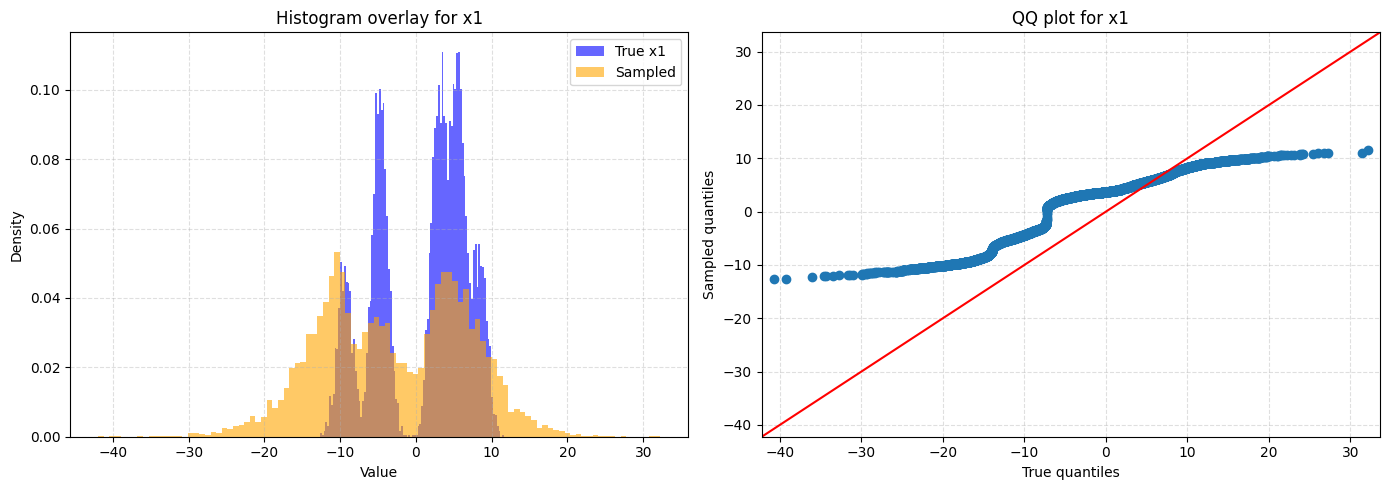

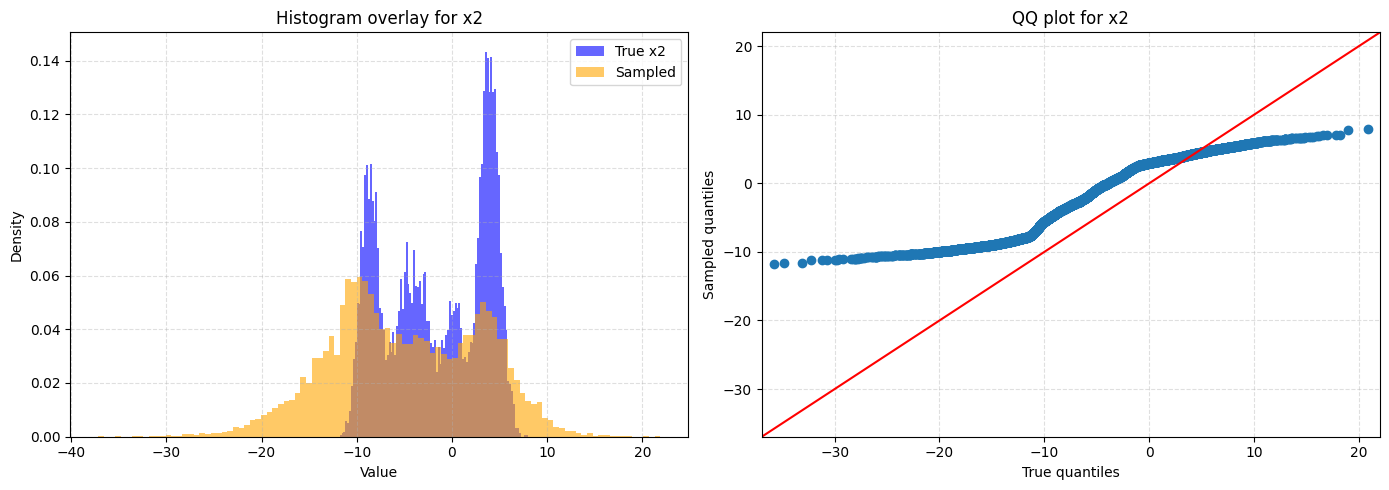

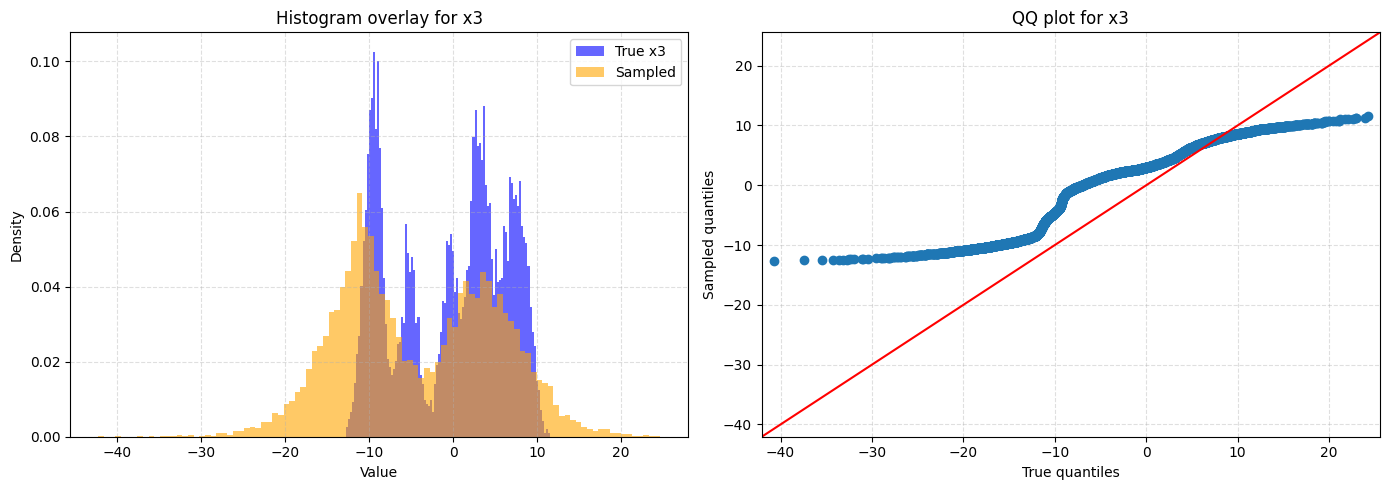

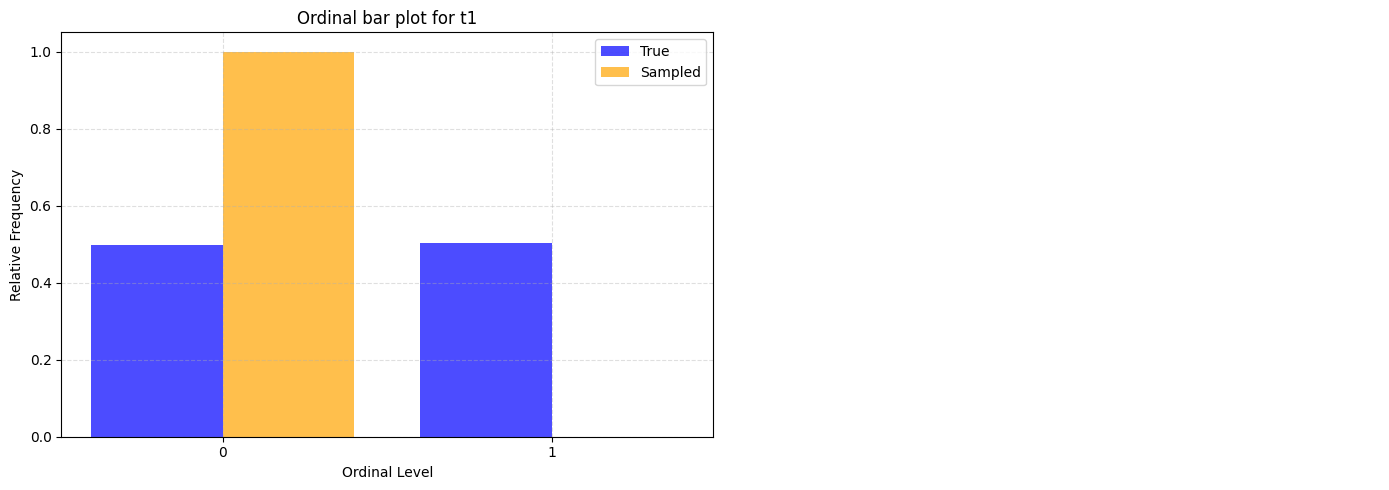

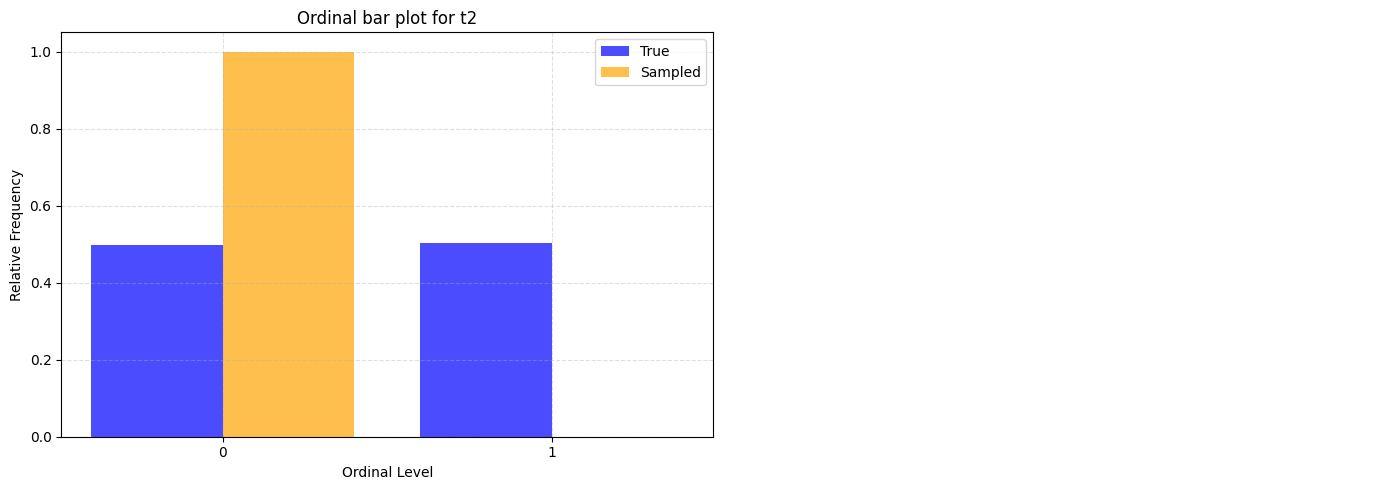

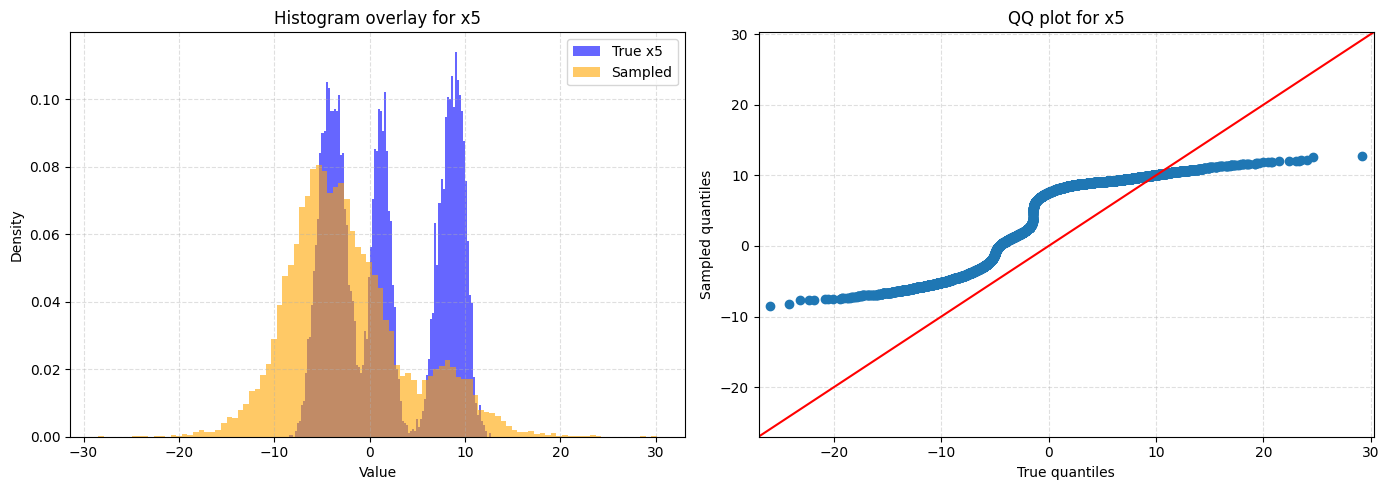

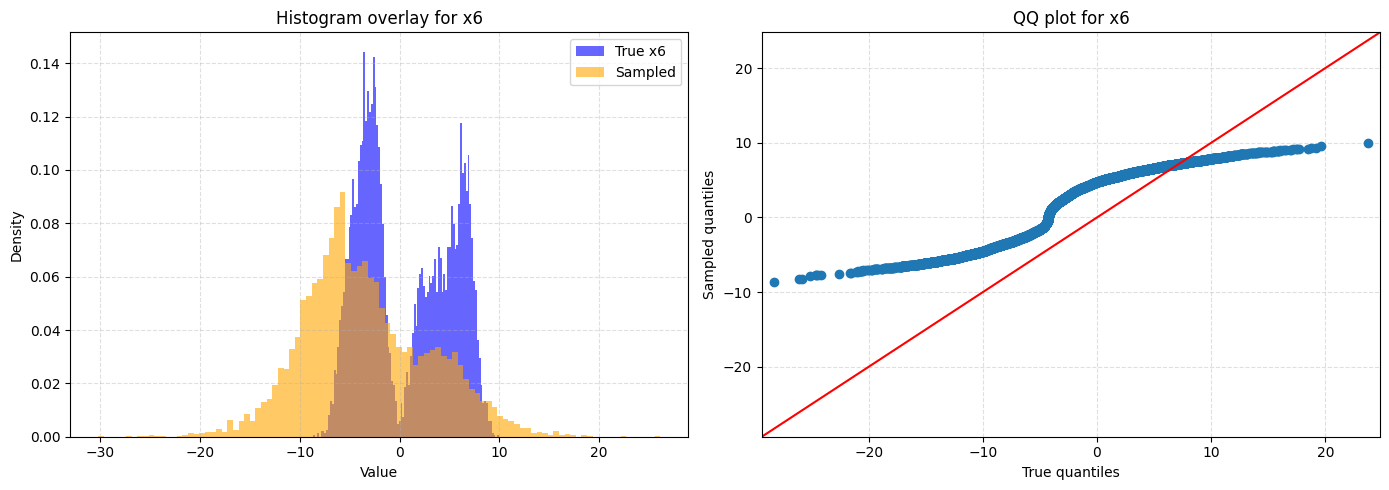

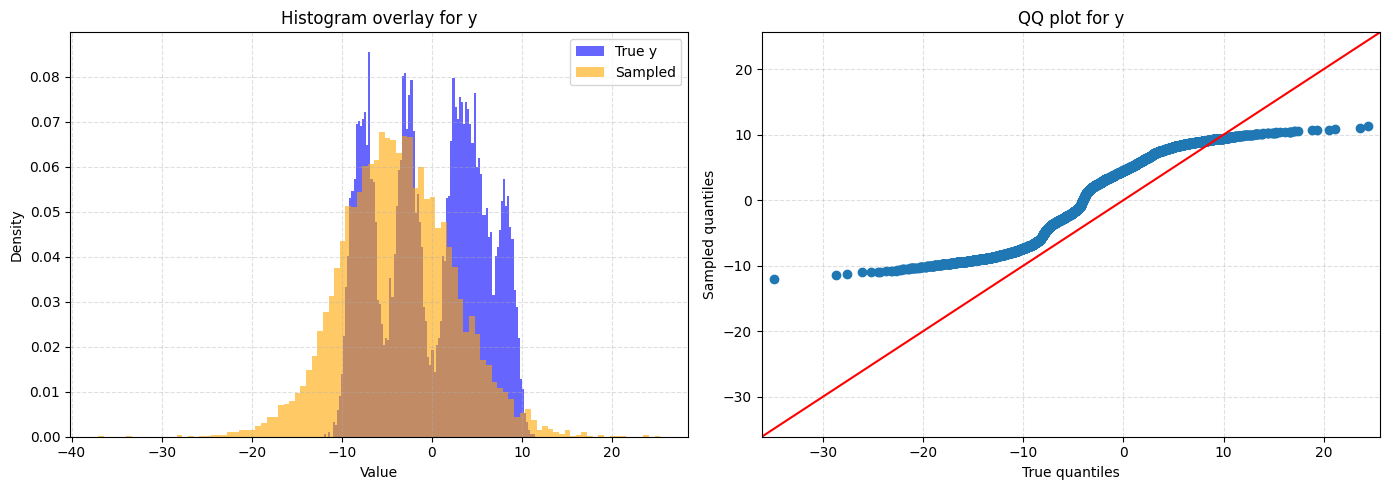

In [12]:
td_model.show_samples_vs_true(train_df)